# Lab 1: Independent Component Analysis

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people.
* The deadline is Wednesday, April 19, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2016] lab01\_Bongers\_Blom", the attached file should be "lab01\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the `# YOUR CODE HERE' comment.
    * For theoretical question, put your solution in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [238]:
%pylab inline

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2, seed=None):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    (Changed to accept seed)
    """
    epsilon = 0.1
    if seed is not None:
        np.random.seed(seed)
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])

The following code generates some toy data to work with.

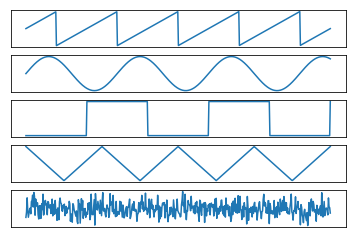

In [5]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$. 

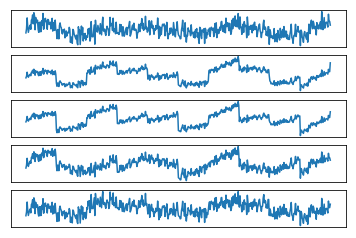

In [6]:
### 1.1 Make mixtures

def make_mixtures(S, A=None):
    return np.dot(A,S)

A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X)

### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the numpy `histogram()` function. 

Plot histograms of the sources and the measurements. 
Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

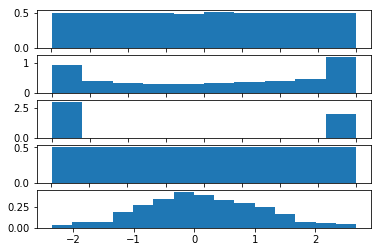

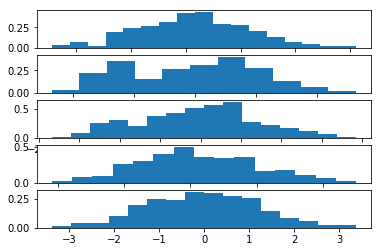

In [7]:
### 1.2 Histogram

def plot_histograms(X):
    """
    Plot the histograms of the signals contained in the rows of X.
    """
    figure()
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plt.hist(X[i, :], bins='auto', normed=True) # X[i, :] contains all the T time-steps of the i-th measurement
        
plot_histograms(S)
plot_histograms(X)

Of the signals only the last signal looks Gaussian. And that's because it is - it was produced by a Gaussian distribution. Then all of the audio signals look (somewhat) Gaussian, which is the result of mixing the pure signals.

Then, the first four signals (the sine-, sawtooth-, square- and triangle-wave) clearly look very non-Gaussian: their mass lies confined precicely between -2 and 2 and, in the case of the first and fourth signal, is distributed completely uniform, and in the case of 2 and 3, bimodal at -2 and 2. (The reason that the histogram of the sine wave is like that of the sqaure wave but with mass spread to the middle is that these waves are essentially the same, but only the sine waves makes a smooth motion between -2 and 2, and the square jumps).

Now, this is good news. ICA doesn't work with signals that are Gaussian. That is, ICA will not be able to separate two Gaussian signals. But if our signals are non-Gaussian we might stand a change of separating the signals again!

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, derive the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

The normalizing constant is not required, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

Plot the activation functions and the corresponding prior distributions. Compare the shape of the priors to the histogram you plotted in the last question.

$$\ln p_0(a) = -\ln \cosh(a) + C = \ln \frac{1}{\cosh(a)}  + C \implies p_0(a)\propto\frac{1}{\cosh(a)}$$

$$\ln p_1(a) + C = -\frac{1}{2}a^2 + \ln\cosh(a) \implies p_1(a)\propto \exp\{-\frac{1}{2}a^2 + \ln\cosh(a)\}= \exp\{-\frac{1}
{2}a^2\}\exp\{\ln\cosh(a)\} = \cosh(a)\exp\{-\frac{1}{2}a^2\} $$

$$\ln p_2(a)=-\frac{1}{4}a^4 + C \implies p_2(a) \propto \exp\{-\frac{1}{4}a^4\}$$

$$\ln p_3(a) = -3\ln(a^2 + 5) +C = \ln(a^2 + 5)^{-3} +C \implies p_3(a) \propto (a^2 + 5)^{-3} $$

Where $C$ is some (each time possibly different) constant.

We can see below in the plots that $p_1$ and $p_2$ have distribution that are very flat-topped and hence with probability mass concentraded rather uniformly around the peak (for these distributions roughly between -2 and 2). This type of distribution corresponds very well to the distributions we see in the histograms of the first three signals: in these the probability mass is confined rather uniformly between -2 and 2 for the first two signals, and bimodal at -2 and 2 for the third signal.

On the other hand $p_0$ and $p_3$ have distributions with sharp peaks and hence with heavier tails. These distributions correspond better to the fourth signal (which is produced by a Gaussian) and all four of the final recorded audio signals, which have started to look somewhat Gaussian as well.

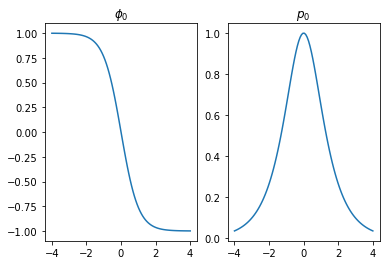

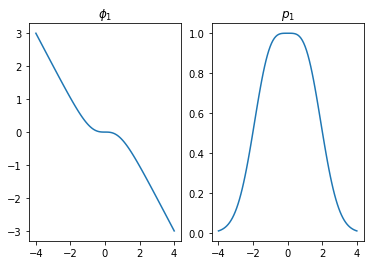

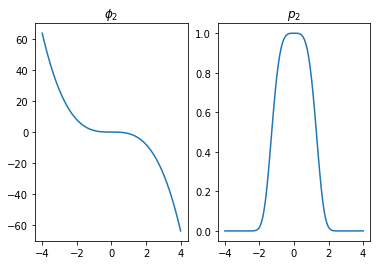

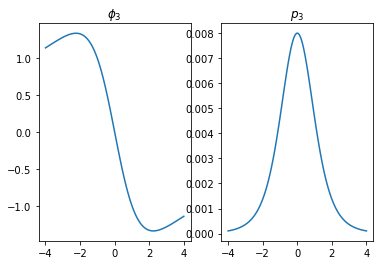

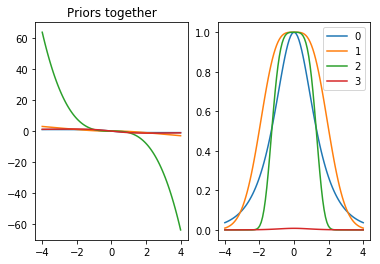

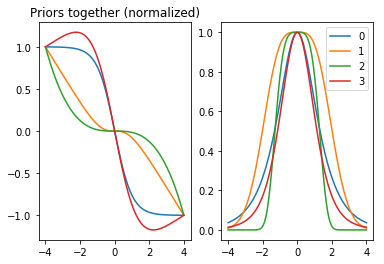

In [364]:
### 1.3 Implicit priors (continued)
# YOUR CODE HERE

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def sigmoid_prime(a):
    return sigmoid(a) * (1 - sigmoid(a))

def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    return 1. / np.cosh(a)

def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    return np.cosh(a) * np.exp(-.5 * np.power(a, 2))

def phi_2(a):
    return -np.power(a, 3)

def p_2(a):
    return np.exp(-.25 * np.power(a, 4))

def phi_3(a):
    return -(6 * a) / (np.power(a,2) + 5)

def p_3(a):
    return np.power((np.power(a, 2) + 5), -3)

def plot_priors(phi, p, a):
    """
    Plot the functions contained in the rows of phi and p.
    """
    d = phi.shape[0]
    for i in range(d):
        figure()
        ax = plt.subplot(1, 2, 1)
        plot(a, phi[i, :])
        title("$\phi_{}$".format(i))
        ax = plt.subplot(1, 2, 2)
        plot(a, p[i, :])
        title("$p_{}$".format(i))

def plot_priors_together(phi, p, a, title):
    """
    Plot the functions contained in the rows of phi and p together in on plot. 
    """
    fig = figure()
    d = phi.shape[0]
    handles_phi = []
    handles_p = []
    for i in range(d):
        plt.subplot(1, 2, 1)
        plt.title(title)
        ax_phi = plot(a, phi[i, :], label=i)
        handles_phi.extend(ax_phi)
        
        plt.subplot(1, 2, 2)
        ax_p = plot(a, p[i, :], label=i)
        
    plt.legend(handles=handles_phi)
    
        
a = linspace(-4, 4, 100)

phi = np.c_[phi_0(a), phi_1(a), phi_2(a), phi_3(a)].T
p = np.c_[p_0(a), p_1(a), p_2(a), p_3(a)].T

# Plotting

plot_priors(phi, p, a)

plot_priors_together(phi, p, a, title='Priors together')

# Scaling the functions for comparison purposes
phi_scaled = np.c_[(1/phi_0(a)[0])*phi_0(a), (1/phi_1(a)[0])*phi_1(a), 
                   (1/phi_2(a)[0])*phi_2(a), (1/phi_3(a)[0])*phi_3(a)].T
p_scaled = np.c_[p_0(a), p_1(a), p_2(a), (1/0.008)*p_3(a)].T # scale up the last distribution for comparison purposes

plot_priors_together(phi_scaled, p_scaled, a, title='Priors together (normalized)')

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf

In [367]:
### 1.4 Whitening
from numpy import dot

def covariance(X):
    m = X.shape[0]
    t = X.shape[1]
    
    # compute mean
    mean = (1/float(m)) * X.sum(axis=0)
    X_hat = X
    for i in range(m):
        # substract mean
        X_hat[i,:] =  X[i,:] - mean

    # compute covariance matrix
    cov = (1/float(m)) * np.dot(X_hat, X_hat.T)
    return cov

def whiten(X):
    
    cov = covariance(X)
    U, l, V = np.linalg.svd(cov, full_matrices=True)
    L_sqrt = np.diag(1. / np.sqrt(l))
        
    W = dot(L_sqrt, V)
    return dot(W, X)

### 1.5 Interpret results of whitening (10 points)
Make scatter plots of the sources, measurements and whitened measurements. Each axis represents a source/measurement and each time-instance is plotted as a dot in this space. You can use the `np.scatter()` function. Describe what you see.

Now compute the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize a covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

Are the signals independent after whitening?

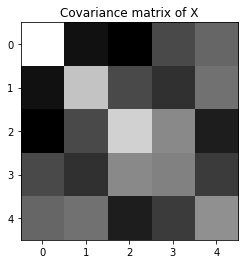

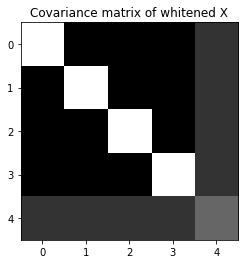

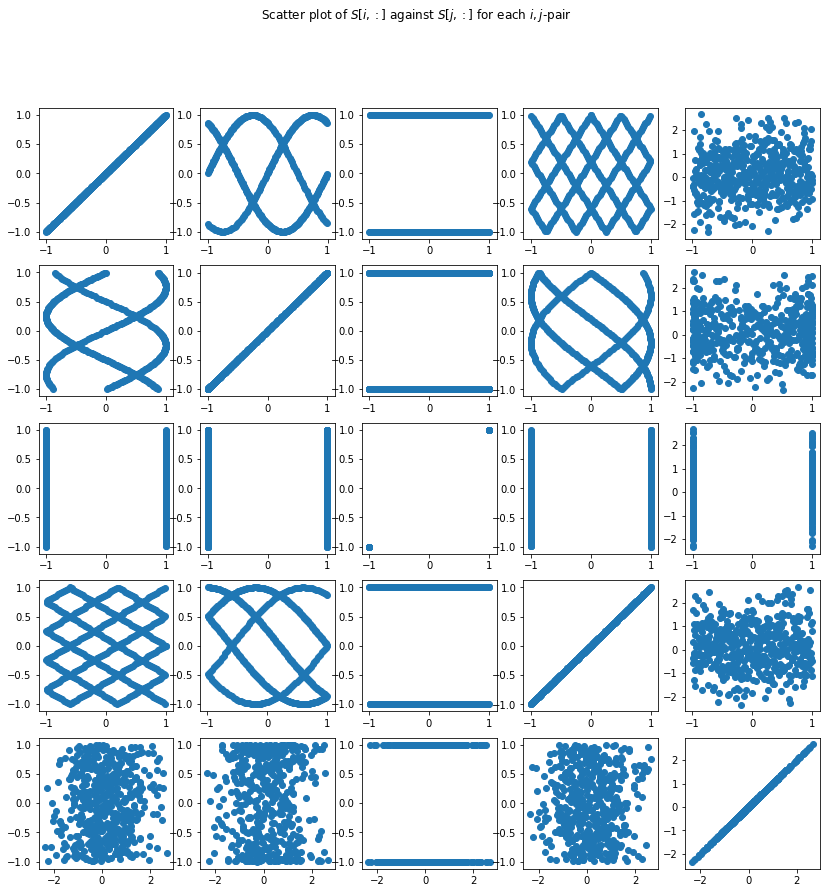

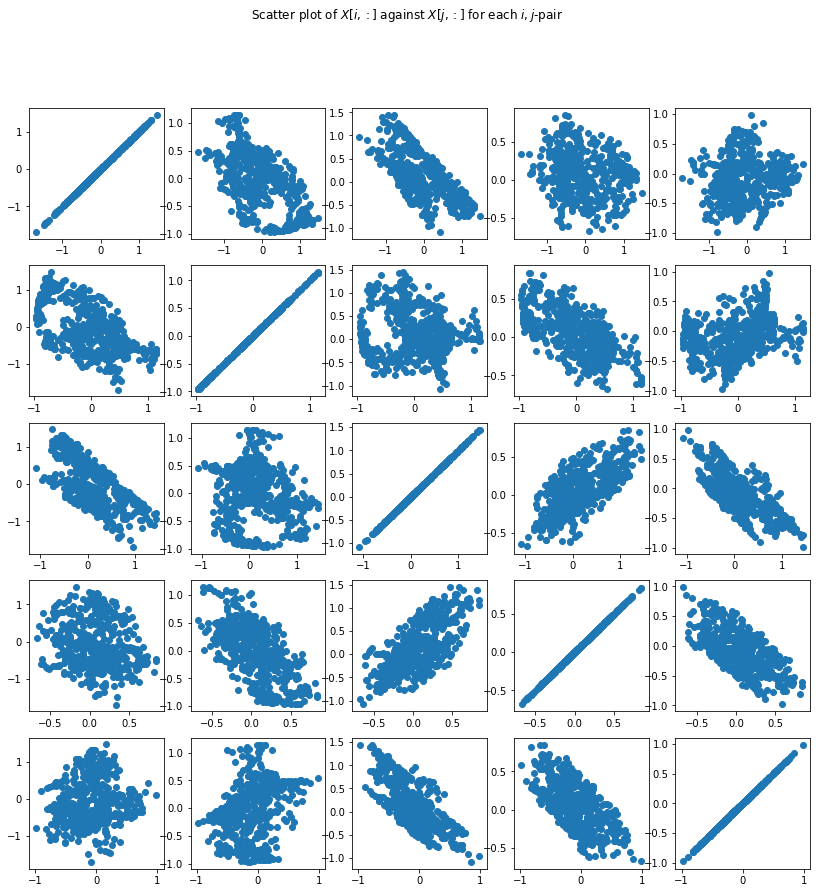

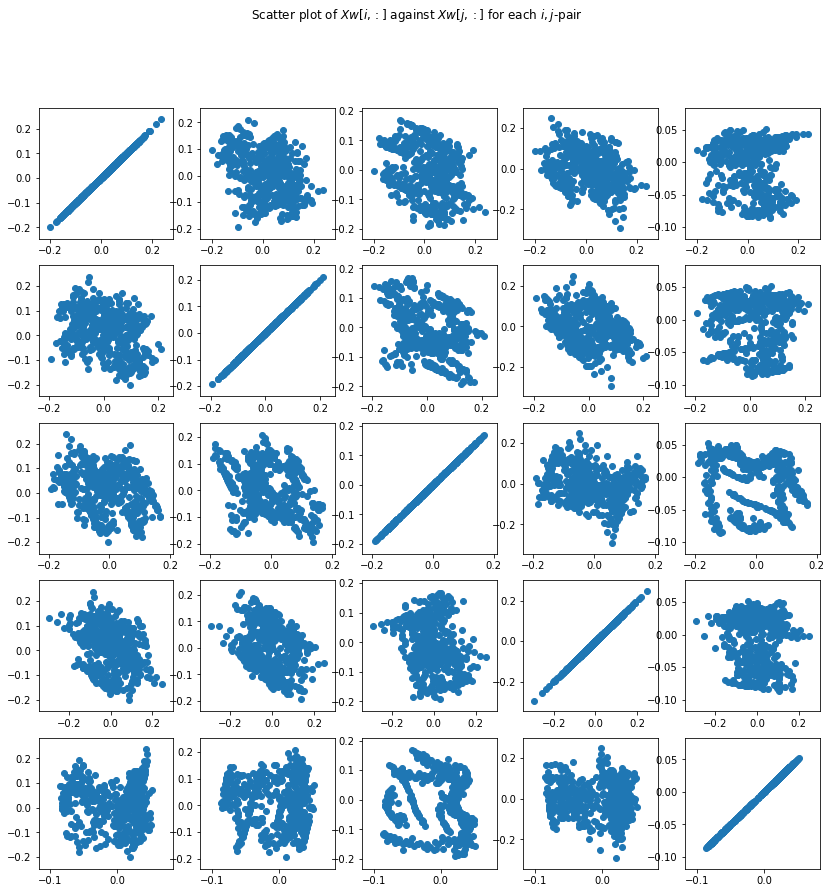

In [368]:
### 1.5 Interpret results of whitening
    
ax = imshow(covariance(X), cmap='gray', interpolation='nearest')
plt.title('Covariance matrix of X')
plt.show()

Xw = whiten(X)
ax = imshow(covariance(Xw), cmap='gray', interpolation='nearest')
plt.title('Covariance matrix of whitened X')
plt.show()

def plot_scatter_table(A, name='A'):
    """
    Plots the scatterplot of each measurement against each other measurement
    """
    d = A.shape[0]
    f, axarr = plt.subplots(d, d, figsize=(14, 14))
    f.suptitle('Scatter plot of ${0}[i,:]$ against ${0}[j,:]$ for each $i,j$-pair'.format(name))
    for i in range(d):
        for j in range(d):
            axarr[i, j].scatter(A[i, :], A[j, :])
    plt.show()
    plt.clf()
    
# Scatter of source matrix S
plot_scatter_table(S, 'S')
# Scatter of data matrix X
plot_scatter_table(X, 'X')
# Scatter of whitened data matrix X
plot_scatter_table(Xw, 'Xw')

After whitening, the datapoints are more sparse and spread compared to the original measurement. We also see that we lost the linear correlation of some of the data in the whitened data that was present before, especially in the plots of dimension 5 against 3 and 4. This indicates that each dimension is now more uncorrelated than before applying the whitening.

We can also see the covariance of the whitened measurement has turned into a diagonal matrix which tells us that the data at each dimension is now more uncorrelated. (Except that column and row 4 in the covariance matrix are slightly muddled: the entry (4,4) is not precisely 1. We blame this on numerical instability of eigenvalue computation.)

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

A covariant algorithm is an algorithm has the same result independently from the scale of quantities [MacKay (2002) Section 3]. It requires that the dimensionality of the data remains consistent throughout the algorithm.

MacKay : http://www.inference.phy.cam.ac.uk/mackay/ica.pdf

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Try to make it efficient, i.e. use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code).

In [130]:
### 1.7 Independent Component Analysis

def ICA(X, activation_function, learning_rate, 
        epsilon=1e-6, max_iter=1e5, seed=None):
    """
    The ICA algorithm as described in MacKay.
    
    Note: we scale the learning rate by data size: data_size**-1 * learning_rate
    This will enable the us to determine a good learning rate 
    that is independent of the size of the data.
    
    :param X: a whitened data matrix X
    :param activation_function: an activation function
    :param learning_rate: the learning rate
    :param epsilon: iteration stops if norm(delta_W) < epsilon 
    :param max_iter: maximal number of iterations
    
    :returns: the estimated W
    """
    W = random_nonsingular_matrix(d=X.shape[0], seed=seed)
    delta_W = W
    data_size = X.shape[1]
    i = 0
    while np.linalg.norm(delta_W) > epsilon and i < max_iter:
        A = dot(W, X)
        Z = activation_function(A)
        X_prime = dot(W.T, A)
        delta_W = data_size**-1 * learning_rate * (W + np.dot(Z, X_prime.T)) # scale learning rate by data size
        W += delta_W
        i += 1
        
        # keep track of progress
        if i % (max_iter / 10) == 0:
            print '{}% of max iterations'.format(i / float(max_iter) * 100)
    
    print 'Finished in {} iterations'.format(i)
    
    return W

def ICA_plot(X, activation_function, learning_rate, 
        epsilon=1e-6, max_iter=1e5, seed=None, 
        true_W=np.zeros((X.shape[0], X.shape[0])),
        plot=True):
    """
    Same function as ICA, but with additional plotting options:
    can plot norm(delta_W) and norm(W-inv(A)) over iterations.
    
    :param X: a whitened data matrix X
    :param activation function: an activation function
    :param learning rate: the learning rate
    :param epsilon: iteration stops if norm(delta_W) < epsilon 
    :param max_iter: maximal number of iterations
    :param seed: optional seed to fix the initialization matrix W (useful for comparison of activation functions)
    :param true_W: inverse(A) if given, otherwise a zeros matrix
    :plot: plot norm(delta_W) and norm(W-true_W) over iterations if set to True 
    
    :returns: the estimated W, [norm(delta_W)], [norm(W-true_W)]
    """
    norms = []
    differences = []
    
    W = random_nonsingular_matrix(d=X.shape[0], seed=seed)
    data_size = X.shape[1]
    norm = 10
    i = 0
    while norm > epsilon and i < max_iter:
        
        A = dot(W, X)
        Z = activation_function(A)
        X_prime = dot(W.T, A)
        delta_W = data_size**-1 * learning_rate * (W + np.dot(Z, X_prime.T)) # scale learning rate by data size
        W += delta_W
        i += 1
        
        if i % (max_iter / 10) == 0:
            print '{}% of max iterations'.format(i / float(max_iter) * 100)
        
        # collect norms for plots
        norm = np.linalg.norm(delta_W)
        difference = np.linalg.norm(W - true_W)
        norms.append(norm)
        differences.append(difference)
    
    # plot norms
    if plot==True:
        plt.loglog(range(len(norms)), norms)
        plt.title('$||\Delta W||$')
        plt.show()
        plt.plot(range(len(differences)), differences)
        plt.title('$||W - A^{-1}||$')
        plt.show()
    
    print 'Finished in {} iterations\n'.format(i)
    
    return W, norms, differences

### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$. Plot the retreived signals for each choice of activation function.

In [247]:
# 1.8 Experiments
# YOUR CODE HERE

def plot_signals_title(X, title=''):
    """
    Plot the signals contained in the rows of X.
    :param title: optional supertitle for the plots
    """
    fig = figure()
    fig.suptitle(title)
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])

def learning_rate_experiment(Xw, activation_function, learning_rates, true_W, max_iter=1e5, seed=1234):
    """
    Experiment with different learning rates.
    """  
    Ws = []
    norms = []
    differences = []
    
    for rate in learning_rates:
        W, n, d = ICA_plot(Xw, activation_function, learning_rate=rate, 
                           epsilon=1e-9, max_iter=max_iter, seed=seed,
                           plot=False, true_W=true_W)
        Ws.append(W)
        norms.append(n)
        differences.append(d)
    
    return Ws, norms, differences        

def experiment(Xw, true_W, max_iter=1e5, seed=1234):
    """
    Experiments below showed that 0.1 is a good learning-rate 
    for all activation-functions except for phi_2: for this we scale phi_2 by 0.1
    """
    activations = [lambda a: phi_0(a), 
                   lambda a: phi_1(a), 
                   lambda a: 0.1 * phi_2(a), # scale down phi_2
                   lambda a: phi_3(a)] 
    
    Ws = []
    norms = []
    differences = []
    
    for activation in activations:
        W, n, d = ICA_plot(Xw, activation, learning_rate=0.1, 
                           epsilon=1e-9, max_iter=max_iter, seed=seed,
                           plot=False, true_W=true_W)
        Ws.append(W)
        norms.append(n)
        differences.append(d)
    
    return Ws, norms, differences


def plot_experiment(Xw, Ws, norms, differences, 
                    labels=['$\phi_0$', 
                            '$\phi_1$', 
                            '$\phi_2$', 
                            '$\phi_3$']):
    """
    Plots:
        - norm(delta_W) (norms) and norm(W-true_W) (differences) against 
          iterations for each of the items indexing.
        - retrieved signals for each of activation function
    :param labels: provide the labels that index the results of the experiments 
                   (e.g. activation functions, or learning rates)
    """
    
    f = plt.figure(1)
    handles = []
    for i, norm in enumerate(norms):
        ax1 = plt.loglog(range(len(norm)), norm, label=labels[i]) 
        handles.extend(ax1)
    plt.title('$||\Delta W||$')
    plt.xlabel('Iterations')
    plt.legend(handles=handles)
    f.show()
    
    g = plt.figure(2)
    handles = []
    for i, difference in enumerate(differences):
        ax2 = plt.plot(range(len(difference)), difference, label=labels[i])
        handles.extend(ax2)
    plt.title('$||W - A^{-1}||$')
    plt.xlabel('Iterations')
    plt.legend(handles=handles)
    g.show()
    
    for i, W in enumerate(Ws):
        plot_signals_title(dot(W, Xw), title=labels[i])

## Experiments for learning rate

It turns out that for each activation function 0.1 is a good learning rate (and 0.01 for ``phi_2``).

In [ ]:
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
Xw = whiten(X)
true_W = np.linalg.inv(A)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

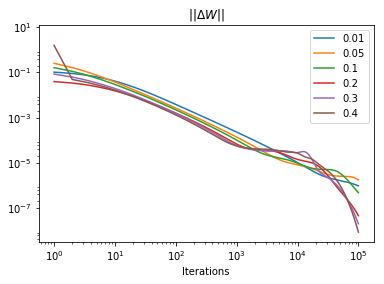

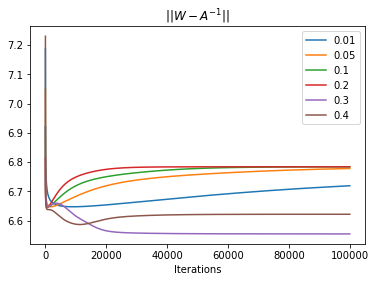

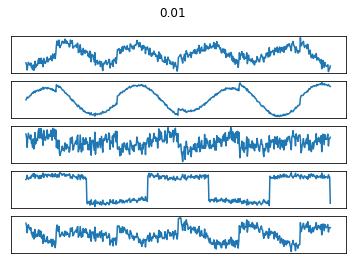

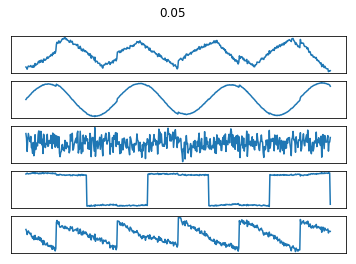

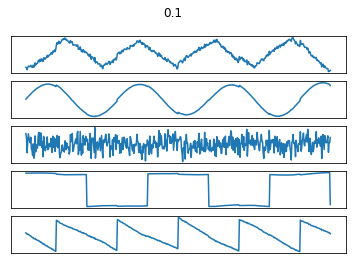

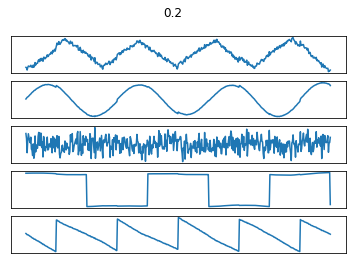

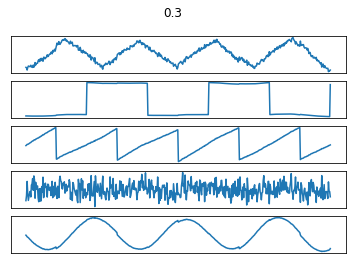

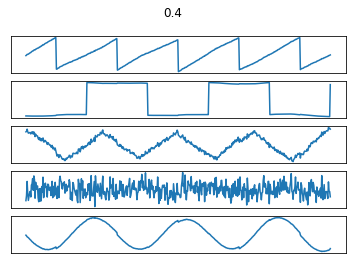

In [256]:
# phi_1
learning_rates=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4] # 0.5 blows up!
Ws, norms, differences = learning_rate_experiment(Xw, phi_1, learning_rates, true_W, max_iter=1e5, seed=1234)
plot_experiment(Xw, Ws, norms, differences, labels=learning_rates)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

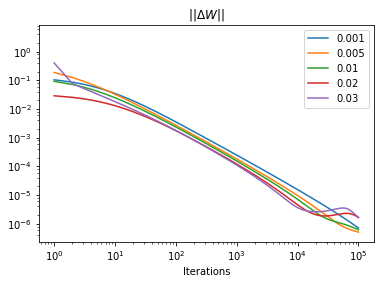

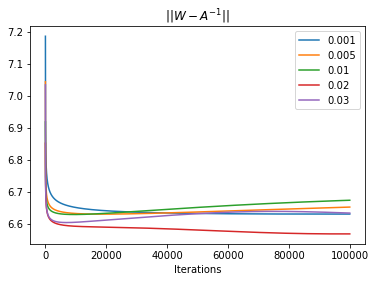

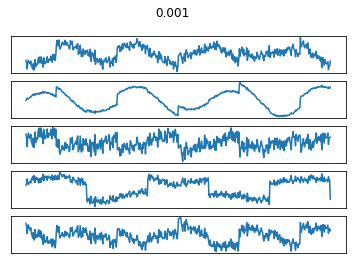

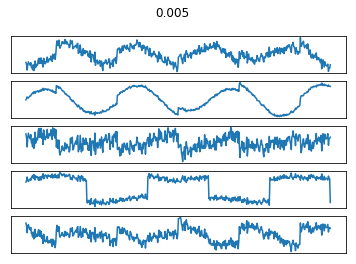

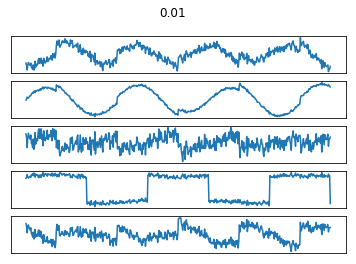

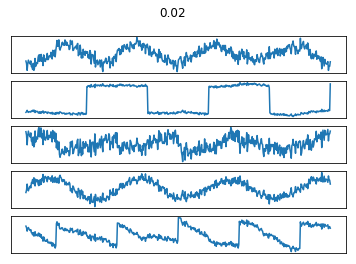

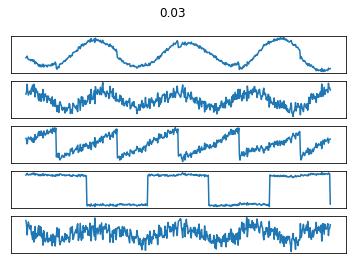

In [263]:
# phi_2
learning_rates=[0.001, 0.005, 0.01, 0.02, 0.03] # 0.04 blows up!
Ws, norms, differences = learning_rate_experiment(Xw, phi_2, learning_rates, true_W, max_iter=1e5, seed=1234)
plot_experiment(Xw, Ws, norms, differences, labels=learning_rates)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

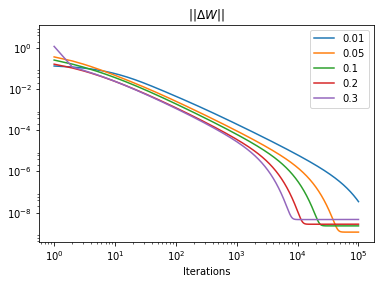

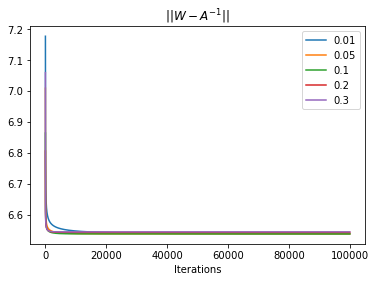

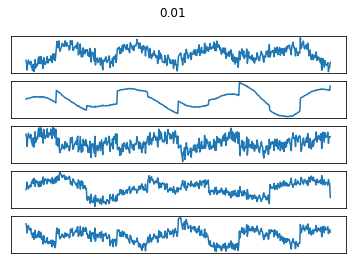

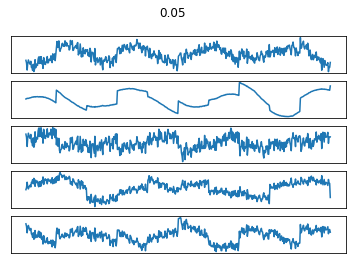

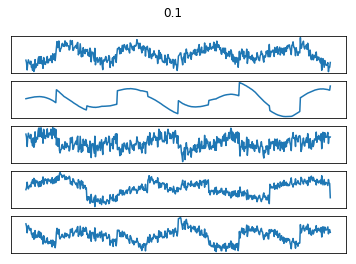

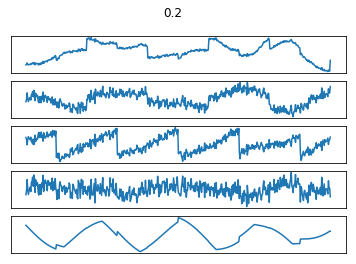

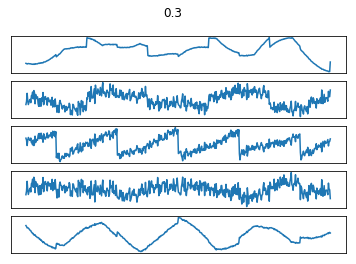

In [264]:
# phi_3
learning_rates=[0.01, 0.05, 0.1, 0.2, 0.3] # 0.4 blows up!
Ws, norms, differences = learning_rate_experiment(Xw, phi_3, learning_rates, true_W, max_iter=1e5, seed=1234)
plot_experiment(Xw, Ws, norms, differences, labels=learning_rates)

## Experiments for activation function

It turns out that ``phi_1`` and ``phi_2`` perform best.

In [270]:
# Initialization
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
Xw = whiten(X)
true_W = np.linalg.inv(A)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

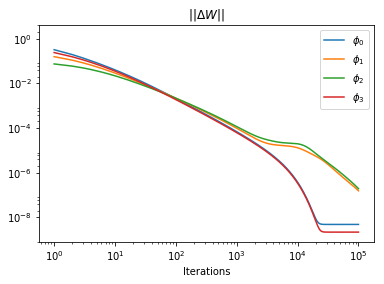

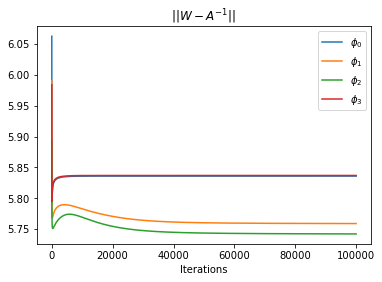

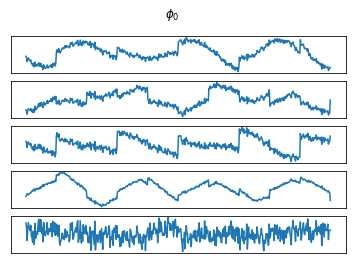

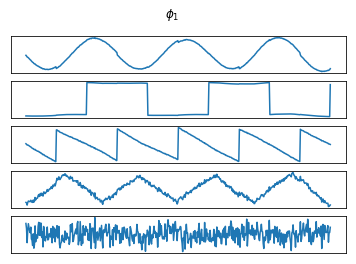

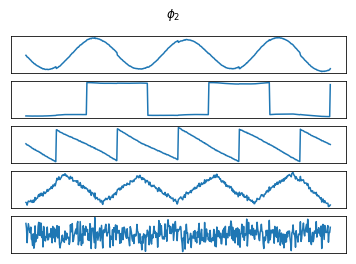

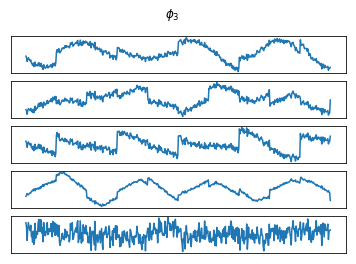

In [271]:
# one seed
Ws, norms, differences = experiment(Xw, true_W, max_iter=1e5)
plot_experiment(Xw, Ws, norms, differences)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

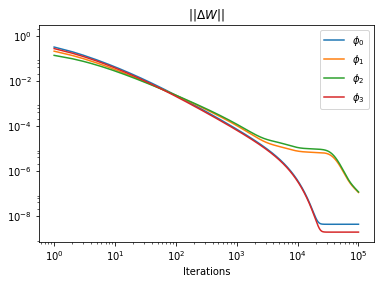

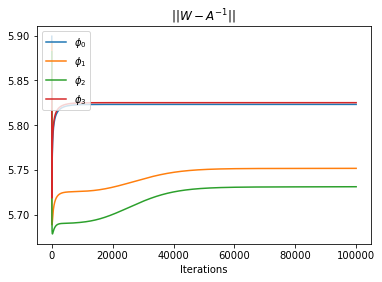

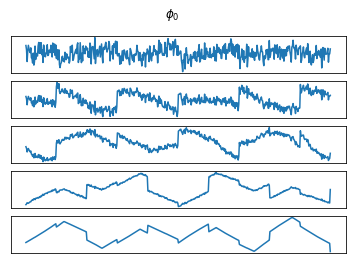

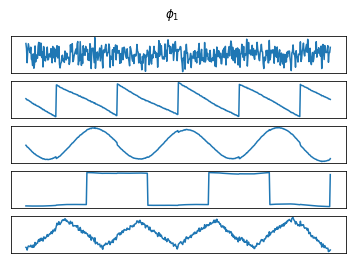

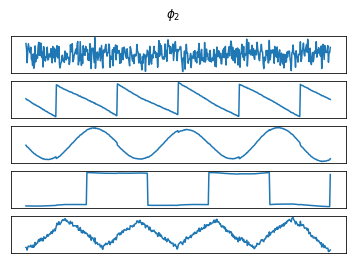

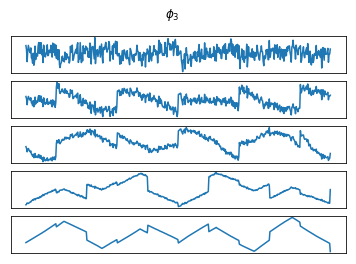

In [272]:
# another seed
Ws, norms, differences = experiment(Xw, true_W, max_iter=1e5, seed=54321)
plot_experiment(Xw, Ws, norms, differences)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

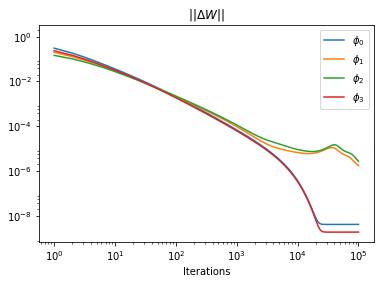

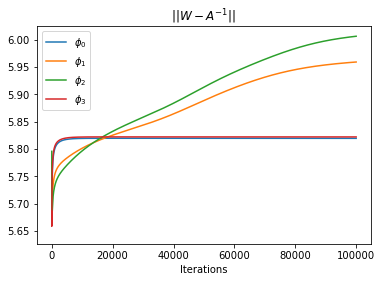

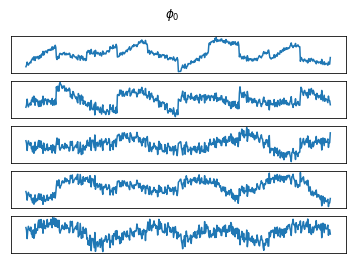

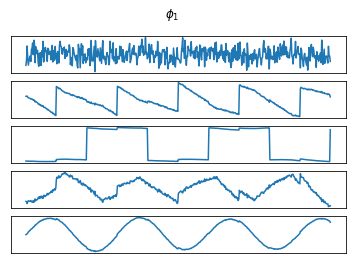

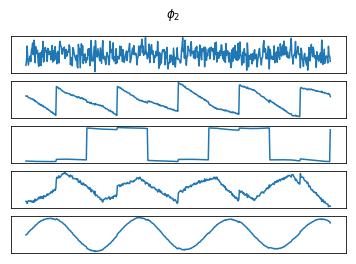

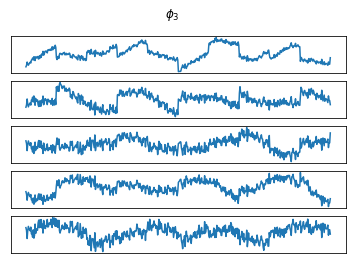

In [273]:
# yet another seed
Ws, norms, differences = experiment(Xw, true_W, max_iter=1e5, seed=99999)
plot_experiment(Xw, Ws, norms, differences)

In [274]:
# Another initalization:
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
Xw = whiten(X)
true_W = np.linalg.inv(A)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

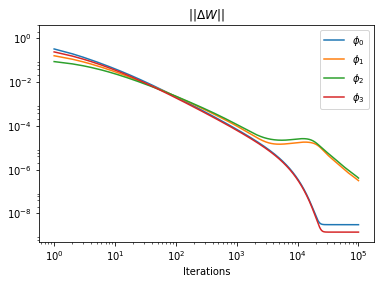

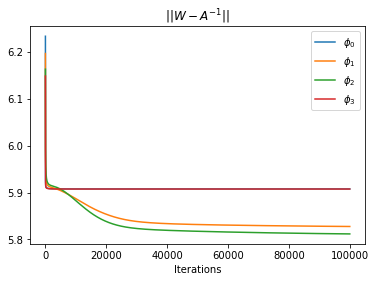

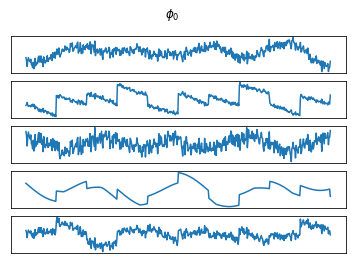

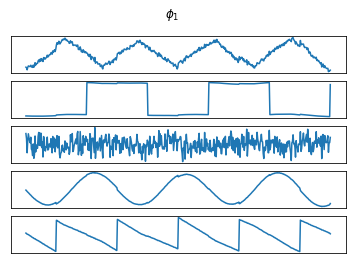

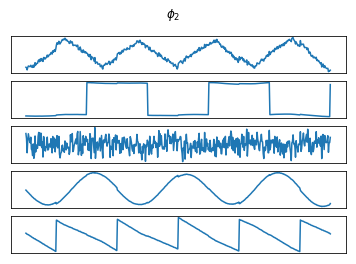

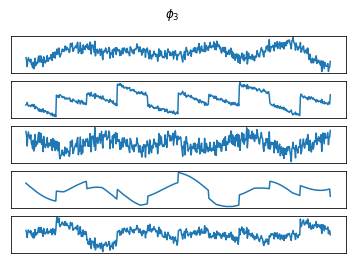

In [277]:
Ws, norms, differences = experiment(Xw, true_W, max_iter=1e5)
plot_experiment(Xw, Ws, norms, differences)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations
Finished in 100000 iterations

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max ite

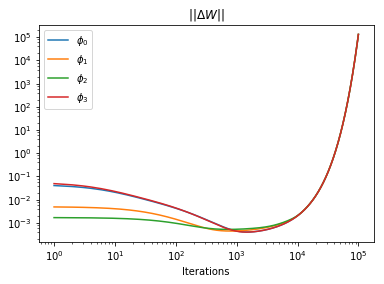

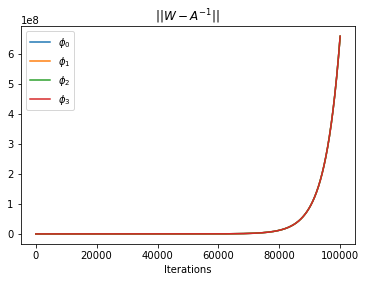

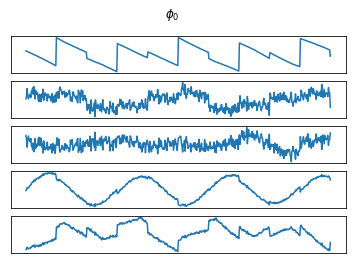

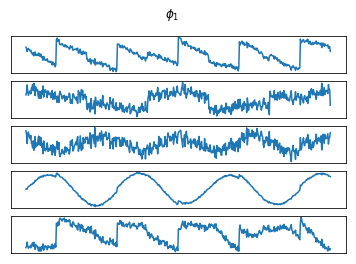

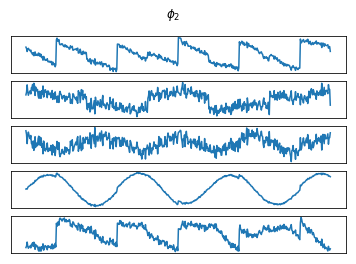

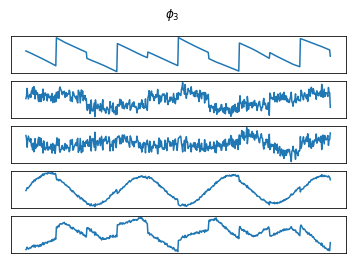

In [293]:
Ws, norms, differences = experiment(X, true_W, max_iter=1e5)
plot_experiment(X, Ws, norms, differences)

### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files and save them to disk using the code below so you can listen to them. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions and report your results.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [278]:
import scipy.io.wavfile
# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

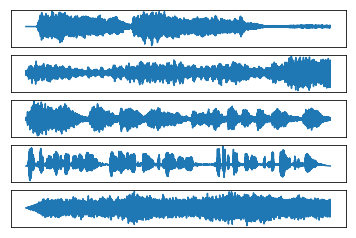

In [279]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)

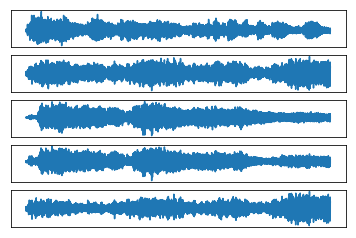

In [371]:
# Saving a mixture to file
A_audio = random_nonsingular_matrix(d=S_audio.shape[0])
X_audio = dot(A_audio, S_audio)
plot_signals(X_audio)

for i in range(5):
    save_wav(X_audio[i,:], 'mix/mix{}.wav'.format(i), 22050)    

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations


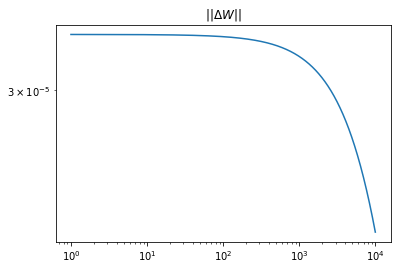

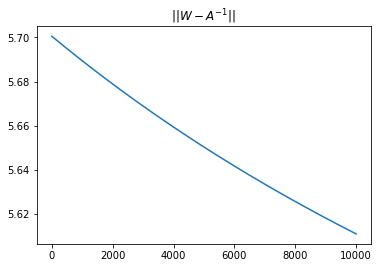

Finished in 10000 iterations



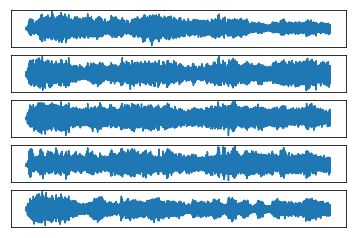

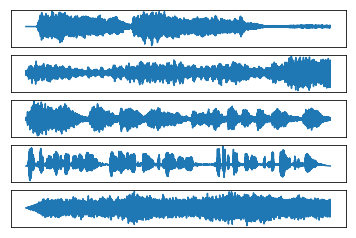

In [374]:
### 1.9 Audio demixing
# YOUR CODE HERE

# phi_0
Xw_audio = whiten(X_audio)
W_true_audio = np.linalg.inv(A_audio)

W_audio, _, _ = ICA_plot(Xw_audio, phi_0, learning_rate=0.1, epsilon=1e-9, 
                         true_W=W_true_audio, max_iter=1e4)

plot_signals(dot(W_audio, Xw_audio))
plot_signals(S_audio)

for i in range(5):
    save_wav(dot(W_audio, Xw_audio)[i,:], 'mix/demix-phi{0}-{1}.wav'.format(activation, i), 22050)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations


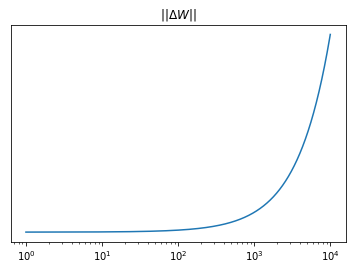

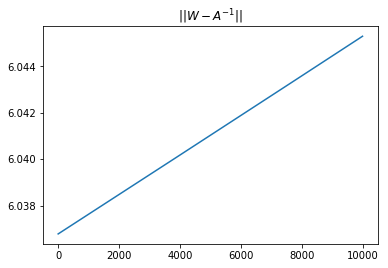

Finished in 10000 iterations



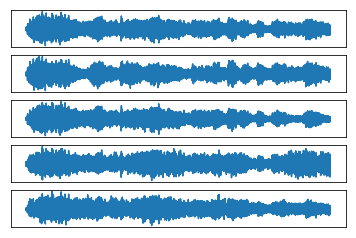

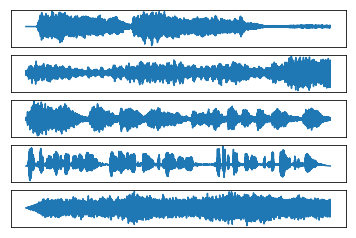

In [375]:
# phi_1

W_audio, _, _ = ICA_plot(Xw_audio, phi_1, learning_rate=0.1, epsilon=1e-9, 
                         true_W=W_true_audio, max_iter=1e4)

plot_signals(dot(W_audio, Xw_audio))
plot_signals(S_audio)

for i in range(5):
    save_wav(dot(W_audio, Xw_audio)[i,:], 'mix/demix-phi{0}-{1}.wav'.format(activation, i), 22050)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations


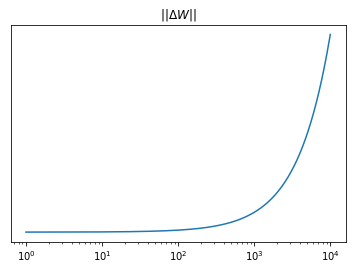

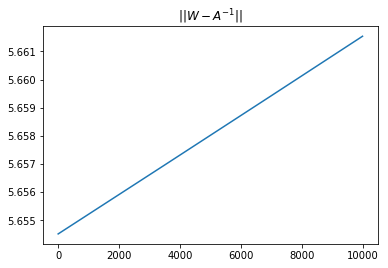

Finished in 10000 iterations



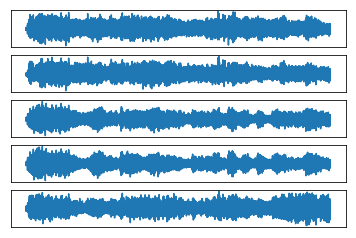

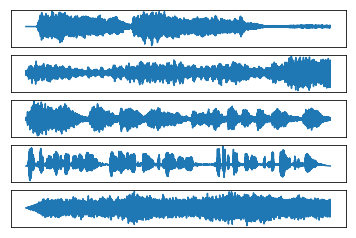

In [376]:
# phi_2

W_audio, _, _ = ICA_plot(Xw_audio, phi_2, learning_rate=0.1, epsilon=1e-9, 
                         true_W=W_true_audio, max_iter=1e4)

plot_signals(dot(W_audio, Xw_audio))
plot_signals(S_audio)

for i in range(5):
    save_wav(dot(W_audio, Xw_audio)[i,:], 'mix/demix-phi{0}-{1}.wav'.format(activation, i), 22050)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations
70.0% of max iterations
80.0% of max iterations
90.0% of max iterations
100.0% of max iterations


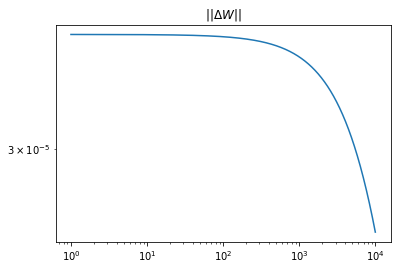

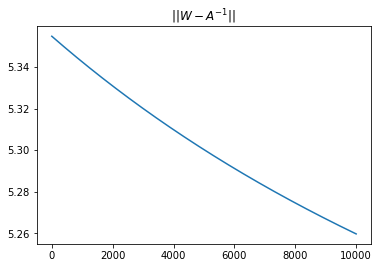

Finished in 10000 iterations



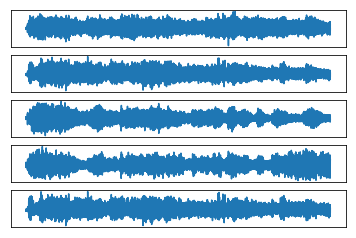

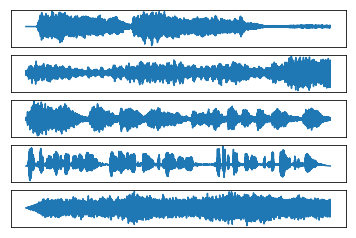

In [377]:
# phi_3

W_audio, _, _ = ICA_plot(Xw_audio, phi_3, learning_rate=0.1, epsilon=1e-9, 
                         true_W=W_true_audio, max_iter=1e4)

plot_signals(dot(W_audio, Xw_audio))
plot_signals(S_audio)

for i in range(5):
    save_wav(dot(W_audio, Xw_audio)[i,:], 'mix/demix-phi{0}-{1}.wav'.format(activation, i), 22050)

## Mixing long sine waves

[Note: this is just something extra we liked to explore]

Creating a sine wave of reasonable length will produce an audio fragment with one smooth pitch. The mixture as well as the signals can be listened to when saved as wav. As we can see (and hear), the ICA works flawless in this case.

In [ ]:
# Mixture of long sine waves:
num_sources_long = 5
signal_length_long = 10000
t_long = linspace(0, 1, signal_length_long)
S_long = np.c_[sine_wave(t_long, period=0.001), 
               sine_wave(t_long, period=0.003),  
               sine_wave(t_long, period=0.005),  
               sine_wave(t_long, period=0.008)].T

k = S_long.shape[0]
A_long = random_nonsingular_matrix(d=k)
X_long = dot(A_long, S_long)
Xw_long = whiten(X_long)
W_long_true = np.linalg.inv(A_long)

plot_signals(S_long)
plot_signals(X_long)

# save the signals and mixtures
for i in range(k):
    save_wav(S_long[i,:], 'signals/5signals-{}.wav'.format(i), 22050)

for i in range(k):
    save_wav(X_long[i,:], 'signals/5mix-signals-{}.wav'.format(i), 22050)

10.0% of max iterations
20.0% of max iterations
30.0% of max iterations
40.0% of max iterations
50.0% of max iterations
60.0% of max iterations


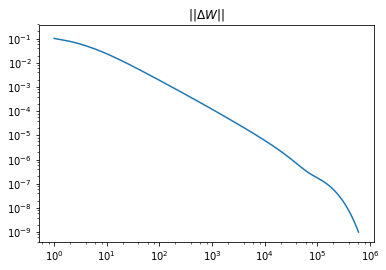

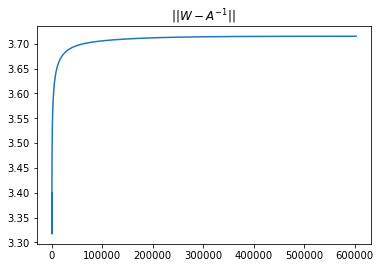

Finished in 602745 iterations



In [59]:
W_long, _, _ = ICA_plot(Xw_long, phi_1, learning_rate=0.1, epsilon=1e-9, true_W=W_long_true, max_iter=1e6)

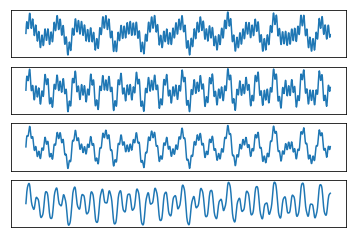

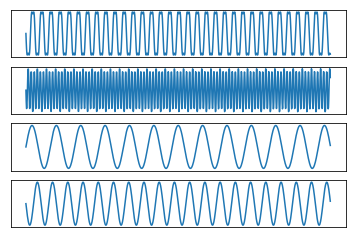

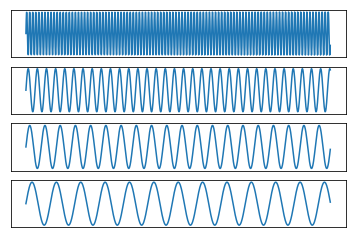

In [66]:
retrieved_S = dot(W_long, Xw_long)

for i in range(k):
    save_wav(retrieved_S[i,:], 'signals/5demix-signals-{}.wav'.format(i), 22050)

plot_signals(X_long[:, 0:1000])
plot_signals(retrieved_S[:, 0:1000])
plot_signals(S_long[:, 0:1000])

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. To do this, you will need the normalizing constant of the distribution, which you can either obtain analytically (good practice!), using computer algebra software (e.g. Sage) or by numerical integration (see scipy.integrate).

In [322]:
from scipy.integrate import quad

# Since we noted that the computed Kurtosis is quite sensitive 
# to the domain over which the integration is performed, we wrote
# the code with an additional argument a that controls the 
# domain of integration [-a, a].

# You can clearly see the effect of a on the final numerical value
# in the computations below.

def normalize(f, a):
    """
    Compute the normalizing constant C of the function f
    by integrating over [-a, a]
    :returns: the normalized function f: 1/C * f
    """
    C, _ = quad(f, -a, a)
    return lambda x: (1 / C) * f(x), C

def kurtosis(f, a):
    """
    Computes the kurtosis of f
    Performs all integration over domain [-a, a]
    """
    g, _ = normalize(f, a)
    mean, _ = quad(lambda x: x * g(x), -a, a)
    var, _ = quad(lambda x: (x - mean)**2 * g(x), -a, a)
    mu4, _ = quad(lambda x: (x - mean)**4 * g(x), -a, a)
    sigma4 = var**2
    return mu4 / sigma4 - 3

priors = [p_0, p_1, p_2, p_3]

print 'Normalizing constants'
for i, prior in enumerate(priors):
    print 'Prior {}:'.format(i)
    print 'a={0}\t{1}'.format(10, normalize(prior, 10)[1])
    print 'a={0}\t{1}'.format(20, normalize(prior, 20)[1])
    print 'a={0}\t{1}'.format(30, normalize(prior, 30)[1])
    print 'a={0}\t{1}'.format('inf', normalize(prior, np.inf)[1])
    print '\n'

print 'Kurtosis'
for i, prior in enumerate(priors):
    print 'Prior {}:'.format(i)
    print 'a={0}\t{1}'.format(10, kurtosis(prior, 10))
    print 'a={0}\t{1}'.format(20, kurtosis(prior, 20))
    print 'a={0}\t{1}'.format(30, kurtosis(prior, 30))
    print 'a={0}\t{1}'.format('inf', kurtosis(prior, np.inf))
    print '\n'

Normalizing constants
Prior 0:
a=10	3.14141105387
a=20	3.14159264535
a=30	3.14159265359
a=inf	3.14159265359


Prior 1:
a=10	4.13273135412
a=20	4.13273135412
a=30	4.13273135412
a=inf	nan


Prior 2:
a=10	2.56369335204
a=20	2.56369335204
a=30	2.56369335204
a=inf	2.56369335204


Prior 3:
a=10	0.021070841568
a=20	0.0210743224773
a=30	0.0210744279265
a=inf	0.0210744441931


Kurtosis
Prior 0:
a=10	1.8807518793
a=20	1.99991963744
a=30	1.99999998227
a=inf	2.0


Prior 1:
a=10	-0.5
a=20	-0.5
a=30	-0.5
a=inf	nan


Prior 2:
a=10	-0.811560384774
a=20	-0.811560384774
a=30	-0.811560384774
a=inf	-0.811560384769


Prior 3:
a=10	2.94876805302
a=20	4.34681605613
a=30	4.87842169688
a=inf	6.0




/Users/daan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in cosh
/Users/daan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: overflow encountered in cosh
/Users/daan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars


We can see that for functions $p_0$ and $p_3$, the answer for the kurtosis depends quite a bit on our choice of integration domain. In these cases we choose the answer given when we set ``a=np.inf``: this answers seems most accurate as it looks like the limiting value of the sequence of values for increasing ``a``. For $p_1$ and $p_2$ the answers already converge for small values of ``a``.

#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

In [323]:
### 1.10.2 Excess Kurtosis
# YOUR CODE HERE
import scipy.stats

K_S = scipy.stats.kurtosis(S, axis=1, fisher=True)
print 'Dummy signals:'
for i, K  in enumerate(K_S):
    print "Signal {0}:\t{1}".format(i, K)
    
K_S_audio = scipy.stats.kurtosis(S_audio, axis=1, fisher=True)
print '\nAudio signals:'
for i, K  in enumerate(K_S_audio):
    print "Signal {0}:\t{1}".format(i, K)

Dummy signals:
Signal 0:	-1.19640244344
Signal 1:	-1.48287113244
Signal 2:	-1.84019700827
Signal 3:	-1.20003840061
Signal 4:	-0.251785042563

Audio signals:
Signal 0:	1.79431516677
Signal 1:	2.06885064075
Signal 2:	1.93609295371
Signal 3:	5.05191720647
Signal 4:	0.538875808159


Kurtosis is a measurement of the 'peakedness' of a distriution. An excess kurtosis greater than 0 (i.e. greater than that of a Gaussian distribution) implies that the distribution is 'pointier' at its mode than a Gaussian and therefore has less probability mass situated there. Equivalently this means that more mass is in the tails of the distribution. The Laplace distribution is a prime example of a distribution with excess kurtosis with taills that decay to zero slower than the taills of a Gaussian. (See https://en.wikipedia.org/wiki/Laplace_distribution.)

On the other hand, a distribution with a negative excess kurtosis (i.e. less than that of a Gaussian distribution), has a more 'flat' top with much more mass concentrated around the mode of the distribution. This means that this distribution has much thinner tails.

We can see this reflected in our priors in two ways. Above, we note that priors $p_0$ and $p_3$ have large positive excess kurtosis - especially prior 3. Priors $p_1$ and $p_2$ on the other hand have negative excess kurtosis. In the plots below we can clearly see the above mentioned characteristics in the shapes of the distributions. In figure 1 $p_1$ and $p_2$ have very flat peaks and $p_0$ and $p_3$ have very sharp peaks. And in figure 2 and 3 (y-axis is in log-scale) we see that the tails of $p_1$ and $p_2$ are decaying rapidly (especially $p_3$!) and $p_0$ and $p_3$ have tails that decay very slowly.

We recall that it was precisly $p_1$ and $p_2$ that worked very well as hypothesized priors for the dummy signals, and $p_0$ and $p_3$ very poorly. Looking at the kurtosis of the dummy signals we can see why! Their kurtosis is also quite negative. (Notice that only signal 4 has a kurtosis pretty close to zero - but we precisely generated this signal from a Guassian source). So qua kurtosis, $p_1$ and $p_2$ are much better matches as distributions for the signals than $p_0$ and $p_3$.

Perhaps this also explains (part of) the poor performance of prior $p_1$ on the audio signals: the audio signals have large positive kurtosis and hence a much more peaked distribution.

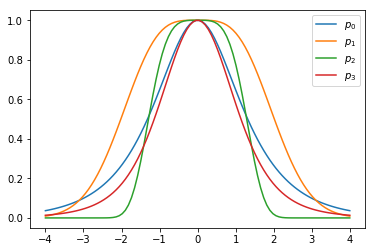

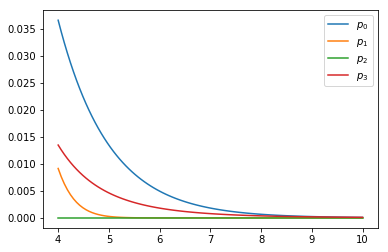

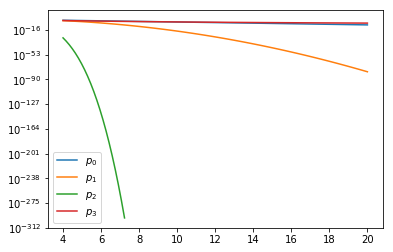

In [363]:
def plot_priors_together_alt(p, a, log=False):
    """
    Plot the functions contained in the rows of phi and p together in on plot. 
    """
    d = p.shape[0]
    handles_p = []
    for i in range(d):
        if log:
            ax_p = plt.semilogy(a, p[i, :], label='$p_{}$'.format(i))
        else:
            ax_p = plt.plot(a, p[i, :], label='$p_{}$'.format(i))
        handles_p.extend(ax_p)        
    plt.legend(handles=handles_p)
    plt.show()
    plt.clf()

a = np.linspace(-4, 4, 100)
# Scaling the functions for comparison purposes
phi_scaled = np.c_[(1/phi_0(a)[0])*phi_0(a), (1/phi_1(a)[0])*phi_1(a), 
                   (1/phi_2(a)[0])*phi_2(a), (1/phi_3(a)[0])*phi_3(a)].T
p_scaled = np.c_[p_0(a), p_1(a), p_2(a), (1/0.008)*p_3(a)].T # scale up the last distribution for comparison purposes
plot_priors_together_alt(p_scaled, a)

a = np.linspace(4, 10, 100)
# Scaling the functions for comparison purposes
phi_scaled = np.c_[(1/phi_0(a)[0])*phi_0(a), (1/phi_1(a)[0])*phi_1(a), 
                   (1/phi_2(a)[0])*phi_2(a), (1/phi_3(a)[0])*phi_3(a)].T
p_scaled = np.c_[p_0(a), p_1(a), p_2(a), (1/0.008)*p_3(a)].T # scale up the last distribution for comparison purposes
plot_priors_together_alt(p_scaled, a)

a = np.linspace(4, 20, 100)
# Scaling the functions for comparison purposes
phi_scaled = np.c_[(1/phi_0(a)[0])*phi_0(a), (1/phi_1(a)[0])*phi_1(a), 
                   (1/phi_2(a)[0])*phi_2(a), (1/phi_3(a)[0])*phi_3(a)].T
p_scaled = np.c_[p_0(a), p_1(a), p_2(a), (1/0.008)*p_3(a)].T # scale up the last distribution for comparison purposes

plot_priors_together_alt(p_scaled, a, log=True)